In [4]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from time import time

In [5]:
def create_subgraphs():
    """
    Creates subgraphs of the Higgs dataset with the full timestamps
    :return: nothing
    """
    activity_time_path = "../network-data/higgs-activity_time.txt"
    activity_time = pd.read_csv(activity_time_path, delimiter = ' ', names=['target', 'source', 'time', 'type'])

    # create high resolution timestamped datasets
    reply_timestamps_file_path = "../output/reply_timestamps.edgelist"
    mention_timestamps_file_path = "../output/mention_timestamps.edgelist"
    retweet_timestamps_file_path = "../output/retweet_timestamps.edgelist"

    activity_time[activity_time['type'] == 'RE'][['source', 'target', 'time']].to_csv(reply_timestamps_file_path, sep=' ', header=False, index=False)
    # activity_time[activity_time['type'] == 'MT'][['source', 'target', 'time']]\
    # .to_csv(mention_timestamps_file_path, sep=' ', header=False, index=False)
    activity_time[activity_time['type'] == 'MT'][['source', 'target', 'time']].to_csv(mention_timestamps_file_path, sep=' ', header=False, index=False)
    # Swap source and target columns in the retweet dataset to effectively simulate the dataflow (as mentioned on the website)
    activity_time[activity_time['type'] == 'RT'][['source', 'target', 'time']].to_csv(retweet_timestamps_file_path, sep=' ', header=False, index=False)

def largest_connected_component(G):
    """
    Returns the largest connected component of a graph
    :param G: graph
    :return: largest connected component
    """
    # not supported for directed networks
    if isinstance(G, nx.DiGraph):
        return G.subgraph(max(nx.weakly_connected_components(G), key=len))
    else:
        return G.subgraph(max(nx.connected_components(G), key=len))

def build_df_from_graph(graph, bin_size=1000):
    graph_df = pd.DataFrame(graph.edges(data=True), columns=['source', 'target', 'attribute'])
    # Extract the 'timestamp' attribute from the 'attribute' column and add it as a separate column
    graph_df['timestamp'] = [d['time'] for d in graph_df['attribute']]
    min_t = min(graph_df['timestamp'])

    # Hardcoded normalizing to ~1000 timesteps
    graph_df['timestamp'] = ((graph_df['timestamp'] - min_t) / bin_size).astype(int)
    # subgraph_df['timestamp'] = ((subgraph_df['timestamp'] - min_t)).astype(int)
    # Drop the 'attribute' column, which is no longer needed
    graph_df.drop('attribute', axis=1, inplace=True)

    graph_df = graph_df.sort_values(by=['timestamp'])
    graph_df.reset_index(drop=True, inplace=True)

    return graph_df

def build_social_network_df(graph):
    social_network_df = pd.DataFrame(graph.edges(data=True), columns=['source', 'target', 'attribute'])
        # Drop the 'attribute' column, which is no longer needed
    social_network_df.drop('attribute', axis=1, inplace=True)
    social_network_df = social_network_df.drop_duplicates()
    return social_network_df

def simulate_spreading(graph_df, social_network_df, seed_node, start_timestamp, end_timestamp, number_of_component_nodes, number_of_total_nodes, name="name_not_given", plot=True):

    graph_nodes = np.zeros(max(social_network_df['source'].max(), social_network_df['target'].max()) + 1)
    print(graph_df['source'].unique())
    #print(np.concatenate((np.array(graph_df['source'].unique()), np.array(graph_df['target'].unique()))))
    graph_nodes[np.concatenate((np.array(graph_df['source'].unique()), np.array(graph_df['target'].unique())))] = 1

    spreading_start_time = graph_df[graph_df['source'] == seed_node]['timestamp'].min()
    min_timestamp = start_timestamp
    max_timestamp = end_timestamp
    # Get the number of nodes in the graph
    infected_nodes = np.zeros(max(social_network_df['source'].max(), social_network_df['target'].max()) + 1)

    informed_nodes =  np.zeros(max(social_network_df['source'].max(), social_network_df['target'].max()) + 1)
    infected_nodes_time = [infected_nodes.sum()/number_of_component_nodes]
    informed_nodes_time = [informed_nodes.sum()/number_of_total_nodes]
    # Iterate over all timestamps
    for timestamp in range(min_timestamp, max_timestamp+1):
        if timestamp == spreading_start_time:
            infected_nodes[seed_node] = 1
            informed_nodes[seed_node] = 1
            informed_nodes[social_network_df[social_network_df['target'] == seed_node]['source']] = 1
            infected_nodes[social_network_df[social_network_df['target'] == seed_node]['source']] = 1
            infected_nodes *= graph_nodes
        print(f'Graph: {name} Timestamp: {timestamp}/{max_timestamp} --- ', end='\r')

        # For each timestamp get the edges that were created on that timestamp
        edges = graph_df[graph_df['timestamp'] == timestamp]
        # Take the dataframe subset where either the source or the target is in the infected nodes
        susceptible_nodes= edges[(infected_nodes[edges['source']] == 1) |(informed_nodes[edges['source']] == 1)  ]['target']
        # Add the susceptible nodes to the infected nodes
        infected_nodes[susceptible_nodes] = 1
        infected_nodes *= graph_nodes
        # Add nodes to the informed nodes that are connected to the infected nodes
        susceptible_informed_nodes = social_network_df[social_network_df['target'].isin(susceptible_nodes)]['source']
        informed_nodes[susceptible_informed_nodes] = 1
        # Add the infected and informed nodes to the infected_nodes_time_dict
        infected_nodes_time.append(infected_nodes.sum()/number_of_component_nodes)
        informed_nodes_time.append(informed_nodes.sum()/number_of_total_nodes)

    # TODO: Add modelling of change in the number of infected and informed nodes

    # last_infected_n = 0
    # infected_nodes_new_it = []
    #
    # # add the difference between current infected and last infected
    # for inf_nodes in infected_nodes_time:
    #     n_inf = len(inf_nodes) - last_infected_n
    #     infected_nodes_new_it.append(n_inf/number_of_nodes)
    #     last_infected_n = len(inf_nodes)
    #
    # infected_nodes_ratio_time_count.append(infected_nodes_ratio_time_count_it)
    # infected_nodes_new.append(infected_nodes_new_it)
    #
    # # average over iterations
    # infected_nodes_ratio_time_count = np.mean(infected_nodes_ratio_time_count, axis=0)
    # infected_nodes_new = np.mean(infected_nodes_new, axis=0)

    if plot:
        plt.plot(np.arange(min_timestamp, max_timestamp+2), infected_nodes_time, label=f'{name}' + ' infected nodes', alpha=0.8)
        plt.plot(np.arange(min_timestamp, max_timestamp+2), informed_nodes_time, label=f'{name}' + ' informed nodes', alpha=0.8)
        plt.legend()
    return infected_nodes, informed_nodes

def get_start_end_combined(subgraph_reply_df, subgraph_mention_df, subgraph_retweet_df):
    start_timestamp_reply = min(subgraph_reply_df['timestamp'])
    start_timestamp_mention = min(subgraph_mention_df['timestamp'])
    start_timestamp_retweet = min(subgraph_retweet_df['timestamp'])
    end_timestamp_reply = max(subgraph_reply_df['timestamp'])
    end_timestamp_mention = max(subgraph_mention_df['timestamp'])
    end_timestamp_retweet = max(subgraph_retweet_df['timestamp'])

    start_timestamp = min(start_timestamp_reply, start_timestamp_mention, start_timestamp_retweet)
    end_timestamp = max(end_timestamp_reply, end_timestamp_mention, end_timestamp_retweet)
    return start_timestamp, end_timestamp

In [6]:
create_subgraphs()

In [7]:
G_reply = nx.read_edgelist("../output/reply_timestamps.edgelist", nodetype=int, data=(('time',int),), create_using=nx.DiGraph)
G_mention = nx.read_edgelist("../output/mention_timestamps.edgelist", nodetype=int, data=(('time', int),),  create_using=nx.DiGraph)
G_retweet = nx.read_edgelist("../output/retweet_timestamps.edgelist", nodetype=int, data=(('time', int),), create_using=nx.DiGraph)
G_social = nx.read_edgelist("../network-data/higgs-social_network.edgelist", nodetype=int, create_using=nx.DiGraph)

G_reply_lcc = largest_connected_component(G_reply)
G_mention_lcc = largest_connected_component(G_mention)
G_retweet_lcc = largest_connected_component(G_retweet)

In [8]:
G_reply_lcc_df = build_df_from_graph(G_reply_lcc)
G_mention_lcc_df = build_df_from_graph(G_mention_lcc)
G_retweet_lcc_df = build_df_from_graph(G_retweet_lcc)


In [9]:
G_reply_df = build_df_from_graph(G_reply)
G_mention_df = build_df_from_graph(G_mention)
G_retweet_df = build_df_from_graph(G_retweet)

In [10]:
G_social_df = build_social_network_df(G_social)

In [10]:
print(G_retweet_lcc)
print(G_mention_lcc)
print(G_reply_lcc)
print(G_social)
print(G_reply)
print(G_retweet)
print(G_mention)

DiGraph with 223833 nodes and 308596 edges
DiGraph with 91606 nodes and 132068 edges
DiGraph with 12839 nodes and 14944 edges
DiGraph with 456626 nodes and 14855842 edges
DiGraph with 38918 nodes and 32523 edges
DiGraph with 256491 nodes and 328132 edges
DiGraph with 116408 nodes and 150818 edges


In [11]:
max_degree_reply = max(G_reply.out_degree(), key=lambda x: x[1])[0]
max_degree_retweet = max(G_retweet.out_degree(), key=lambda x: x[1])[0]
max_degree_mention = max(G_mention.out_degree(), key=lambda x: x[1])[0]

print(max_degree_reply)

677


In [12]:
start_timestamp, end_timestamp = get_start_end_combined(G_reply_lcc_df, G_mention_lcc_df, G_retweet_lcc_df)
print(start_timestamp)
print(end_timestamp)

0
604


[213163  18038   6695 ... 296008  34216  97296]


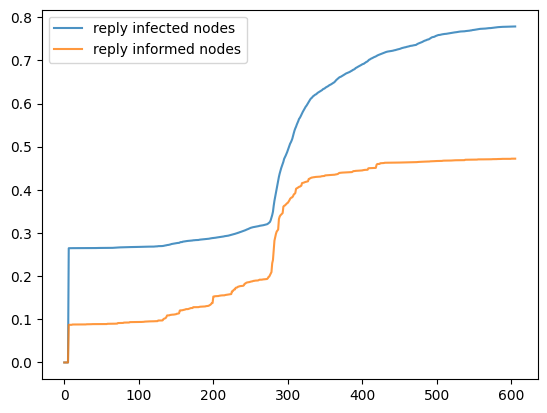

In [13]:
infected_nodes_reply, informed_nodes_reply = simulate_spreading(G_reply_lcc_df, G_social_df, max_degree_reply, start_timestamp, end_timestamp, len(G_reply_lcc.nodes()), len(G_social.nodes()), name="reply", plot=True)

[ 50329  84647      8 ...  30839  16017 101208]
[213163      8   2417 ... 214170  97296 338829]


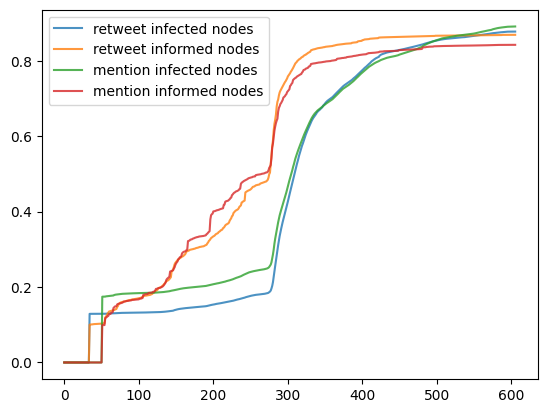

In [14]:
infected_nodes_retweet, informed_nodes_retweet = simulate_spreading(G_retweet_lcc_df, G_social_df, max_degree_retweet, start_timestamp, end_timestamp, len(G_retweet_lcc.nodes()), len(G_social.nodes()), name="retweet", plot=True)
infected_nodes_mention, informed_nodes_mention = simulate_spreading(G_mention_lcc_df, G_social_df, max_degree_mention, start_timestamp, end_timestamp, len(G_mention_lcc.nodes()), len(G_social.nodes()), name="mention", plot=True)


raph: mention Timestamp: 8/604 --- Graph: mention Timestamp: 55/604 --- Graph: mention Timestamp: 96/604 --- Graph: mention Timestamp: 124/604 --- Graph: mention Timestamp: 143/604 --- Graph: mention Timestamp: 149/604 --- Graph: mention Timestamp: 154/604 --- Graph: mention Timestamp: 158/604 --- Graph: mention Timestamp: 164/604 --- Graph: mention Timestamp: 184/604 --- Graph: mention Timestamp: 195/604 --- Graph: mention Timestamp: 202/604 --- Graph: mention Timestamp: 210/604 --- Graph: mention Timestamp: 217/604 --- Graph: mention Timestamp: 222/604 --- Graph: mention Timestamp: 229/604 --- Graph: mention Timestamp: 233/604 --- Graph: mention Timestamp: 238/604 --- Graph: mention Timestamp: 243/604 --- Graph: mention Timestamp: 247/604 --- Graph: mention Timestamp: 252/604 --- Graph: mention Timestamp: 265/604 --- Graph: mention Timestamp: 273/604 --- Graph: mention Timestamp: 277/604 --- Graph: mention Timestamp: 280/604 --- Graph: mention Timestamp: 283/604 --- Graph: mention Ti

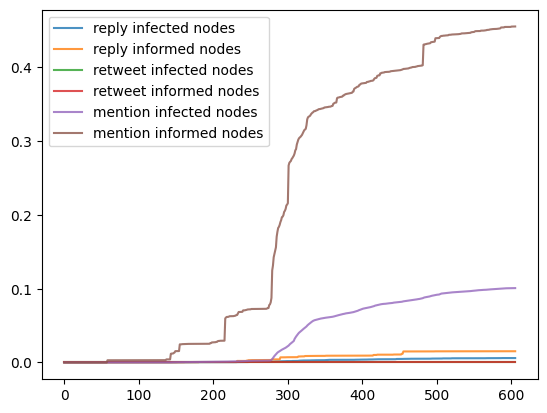

In [21]:
max_in_degree_reply = max(G_reply.in_degree(), key=lambda x: x[1])[0]
max_in_degree_retweet = max(G_retweet.in_degree(), key=lambda x: x[1])[0]
max_in_degree_mention = max(G_mention.in_degree(), key=lambda x: x[1])[0]

infected_nodes_reply_in, informed_nodes_reply_in = simulate_spreading(G_reply_lcc_df, G_social_df, max_in_degree_reply, start_timestamp, end_timestamp, len(G_reply_lcc.nodes()), len(G_social.nodes()), name="reply", plot=True)
infected_nodes_retweet_in, informed_nodes_retweet_in = simulate_spreading(G_retweet_lcc_df, G_social_df, max_in_degree_retweet, start_timestamp, end_timestamp, len(G_retweet_lcc.nodes()), len(G_social.nodes()), name="retweet", plot=True)
infected_nodes_mention_in, informed_nodes_mention_in = simulate_spreading(G_mention_lcc_df, G_social_df, max_in_degree_mention, start_timestamp, end_timestamp, len(G_mention_lcc.nodes()), len(G_social.nodes()), name="mention", plot=True)

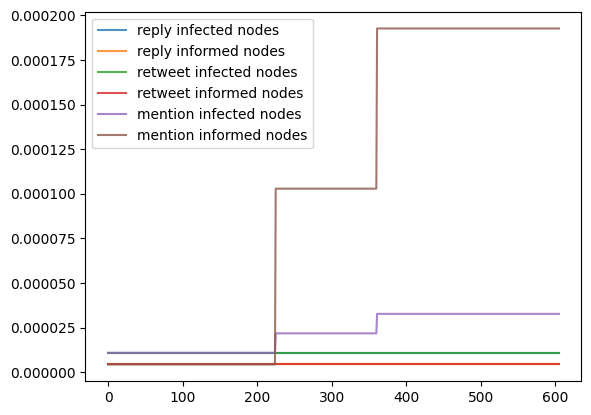

In [31]:
max_out_degree_social = max(G_social.out_degree(), key=lambda x: x[1])[0]

infected_nodes_reply_out_social, informed_nodes_reply_out_social = simulate_spreading(G_reply_lcc_df, G_social_df, max_out_degree_social, start_timestamp, end_timestamp, len(G_mention_lcc.nodes()), len(G_social.nodes()), name="reply", plot=True)
infected_nodes_retweet_out_social, informed_nodes_retweet_out_social = simulate_spreading(G_retweet_lcc_df, G_social_df, max_out_degree_social, start_timestamp, end_timestamp, len(G_mention_lcc.nodes()), len(G_social.nodes()), name="retweet", plot=True)
infected_nodes_mention_out_social, informed_nodes_mention_out_social = simulate_spreading(G_mention_lcc_df, G_social_df, max_out_degree_social, start_timestamp, end_timestamp, len(G_mention_lcc.nodes()), len(G_social.nodes()), name="mention", plot=True)

In [38]:
max_in_degree_social = sorted(G_social.in_degree(), key=lambda x: x[1], reverse=True)[1][0]
print(max_in_degree_social)
print(G_reply.out_degree(max_in_degree_social))
print(G_reply.in_degree(max_in_degree_social))

206
15
0


raph: retweet Timestamp: 5/604 --- Graph: retweet Timestamp: 10/604 --- Graph: retweet Timestamp: 15/604 --- Graph: retweet Timestamp: 19/604 --- Graph: retweet Timestamp: 24/604 --- Graph: retweet Timestamp: 29/604 --- Graph: retweet Timestamp: 34/604 --- Graph: retweet Timestamp: 39/604 --- Graph: retweet Timestamp: 43/604 --- Graph: retweet Timestamp: 48/604 --- Graph: retweet Timestamp: 53/604 --- Graph: retweet Timestamp: 58/604 --- Graph: retweet Timestamp: 63/604 --- Graph: retweet Timestamp: 68/604 --- Graph: retweet Timestamp: 73/604 --- Graph: retweet Timestamp: 78/604 --- Graph: retweet Timestamp: 82/604 --- Graph: retweet Timestamp: 87/604 --- Graph: retweet Timestamp: 91/604 --- Graph: retweet Timestamp: 96/604 --- Graph: retweet Timestamp: 101/604 --- Graph: retweet Timestamp: 106/604 --- Graph: retweet Timestamp: 111/604 --- Graph: retweet Timestamp: 116/604 --- Graph: retweet Timestamp: 121/604 --- Graph: retweet Timestamp: 126/604 --- Graph: retweet Timestamp: 131/604 

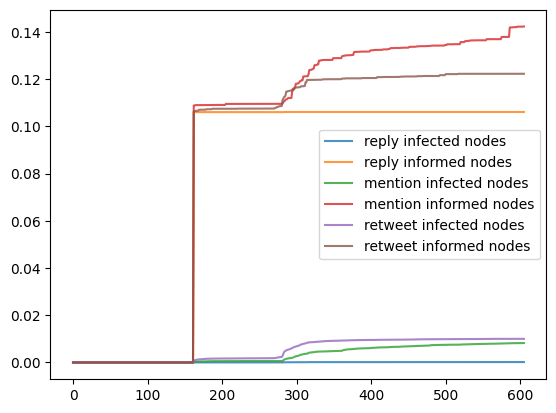

In [39]:
infected_nodes_reply_in_social, informed_nodes_reply_in_social = simulate_spreading(G_reply_lcc_df, G_social_df, max_in_degree_social, start_timestamp, end_timestamp, len(G_mention_lcc.nodes()), len(G_social.nodes()), name="reply", plot=True)
infected_nodes_mention_in_social, informed_nodes_mention_in_social = simulate_spreading(G_mention_lcc_df, G_social_df, max_in_degree_social, start_timestamp, end_timestamp, len(G_mention_lcc.nodes()), len(G_social.nodes()), name="mention", plot=True)
infected_nodes_retweet_in_social, informed_nodes_retweet_in_social = simulate_spreading(G_retweet_lcc_df, G_social_df, max_in_degree_social, start_timestamp, end_timestamp, len(G_mention_lcc.nodes()), len(G_social.nodes()), name="retweet", plot=True)

In [28]:
max_in_degree_social = max(G_social.in_degree(), key=lambda x: x[1])
print(max_in_degree_social)
print(G_social.in_degree(88))

(1503, 51386)
45221
